# I. Load libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [2]:
heart = pd.read_csv('heart_new.csv', index_col=0)
heart.drop(columns='ST_depression_bins', inplace=True)
heart.head()

,age,sex,pain_type,restingBP,chol,fasting_sugar,resting_ecg,maxHR,exercise_angina,ST_depression,ST_peak_slope,vessels_fluoro,thal_severity,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X = heart.drop(columns='heart_disease')
y = heart.heart_disease

# II. Simple modeling to see how the current state of our dataset performs in predicting heart disease

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)
target_prediction = model.predict(X_test) 

In [6]:
print("Accuracy: ", metrics.accuracy_score(y_test, target_prediction))

Accuracy:  0.6271186440677966


### New Dataframe based on only those with higher than average maximum heart rates [(AHA)](https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates)

In [7]:
# Create a list of rows containing only those with higher than average maximum heart rates
# The American Heart Associated defines higher than avgerage heart rate as any heart rate greater than 220 minus one's age
def maxHR_above_avg():
    above_avg = []
    
    for index, row in heart.iterrows():
        if (220 - row['age'] < row['maxHR']):
            above_avg.append(row['maxHR'])
        else:
            above_avg.append(False)
    
    return above_avg

# Create a new column in heart dataframe
heart['maxHR_above_avg'] = maxHR_above_avg()

# Create a list of the indices where maxHR is above average
maxHR_high_list = heart[heart['maxHR_above_avg'] != False].index.tolist()

# Create new dataframe based on this information and drop redundant column
maxHR_high = heart.loc[maxHR_high_list]
maxHR_high.drop(columns='maxHR_above_avg', inplace=True)
heart.drop(columns='maxHR_above_avg', inplace=True)
maxHR_high.head()

,age,sex,pain_type,restingBP,chol,fasting_sugar,resting_ecg,maxHR,exercise_angina,ST_depression,ST_peak_slope,vessels_fluoro,thal_severity,heart_disease
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1
21,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1


In [8]:
# Check value counts in target column to ensure a fair enough split in the new sample
maxHR_high['heart_disease'].value_counts()

1    41
0    21
Name: heart_disease, dtype: int64

In [9]:
X = maxHR_high.drop(columns='heart_disease')
y = maxHR_high.heart_disease

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [11]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)
target_prediction = model.predict(X_test) 

In [12]:
print("Accuracy: ", metrics.accuracy_score(y_test, target_prediction))

Accuracy:  0.7692307692307693


# III. Feature Engineering

## Remove irrelevant features for classification

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

features = heart.drop(columns='heart_disease')
target = heart.heart_disease

# Select two features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=5)
features_kbest = chi2_selector.fit_transform(features, target)

print("Original number of features: ", features.shape[1])
print("Reduced number of features: ", features_kbest.shape[1])

Original number of features:  13
Reduced number of features:  5


In [14]:
# New dataframe after dropping least relevant features
heart5 = pd.DataFrame(features_kbest, columns=['pain_type', 'maxHR', 'exercise_angina', 'ST_depression', 'vessels_fluoro'])
heart5['heart_disease'] = heart['heart_disease']
heart5.head()

,pain_type,maxHR,exercise_angina,ST_depression,vessels_fluoro,heart_disease
0,3.0,150.0,0.0,2.3,0.0,1.0
1,2.0,187.0,0.0,3.5,0.0,1.0
2,1.0,172.0,0.0,1.4,0.0,1.0
3,1.0,178.0,0.0,0.8,0.0,1.0
4,0.0,163.0,1.0,0.6,0.0,1.0


In [15]:
X = heart5.drop(columns='heart_disease')
y = heart.heart_disease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)
target_prediction = model.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(y_test, target_prediction))

Accuracy:  0.5423728813559322


No change in accuracy compared to original dataset.

## Remove highly correlated features

In [16]:
heart_corr = pd.read_csv('heart_new.csv', index_col=0)
heart_corr.drop(columns='ST_depression_bins', inplace=True)
heart_corr.head()

,age,sex,pain_type,restingBP,chol,fasting_sugar,resting_ecg,maxHR,exercise_angina,ST_depression,ST_peak_slope,vessels_fluoro,thal_severity,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [17]:
# Create correlation matrix
corr_matrix = heart_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
heart_corr.drop(heart_corr.columns[to_drop], axis=1).head()

,age,sex,pain_type,restingBP,chol,fasting_sugar,resting_ecg,maxHR,exercise_angina,ST_depression,ST_peak_slope,vessels_fluoro,thal_severity,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


No highly correlated features.

# IV: Modeling

## Comparing Regression Models

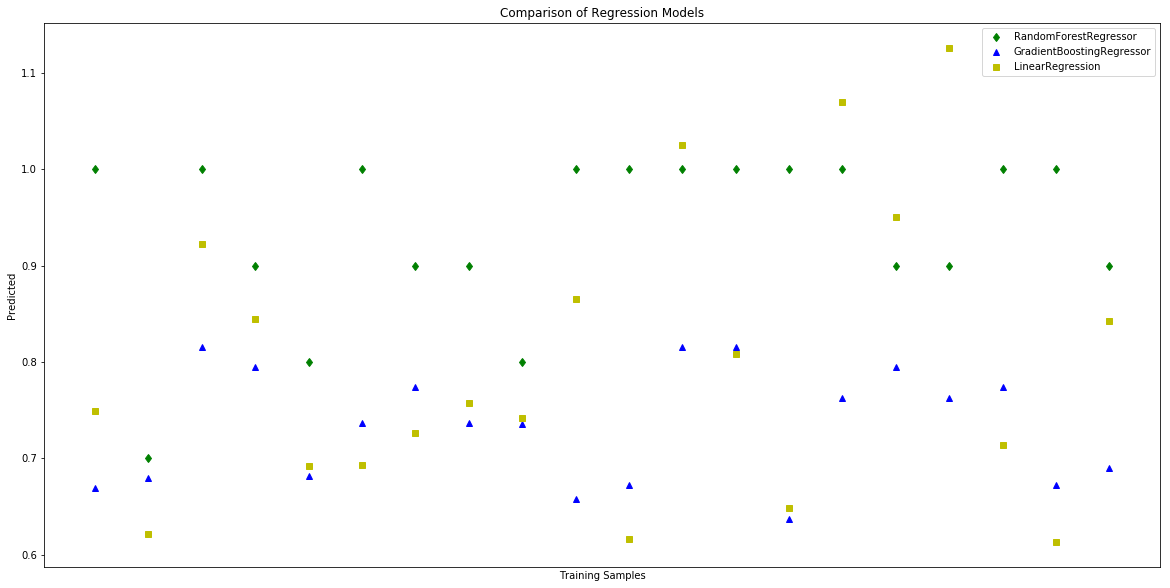

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

X = heart.drop(columns='heart_disease')
y = heart['heart_disease']

reg1 = RandomForestRegressor(random_state=1, n_estimators=10)
reg2 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

xt = X[:20]

plt.figure(figsize=(20, 10))
plt.plot(reg1.predict(xt), 'gd', label='RandomForestRegressor')
plt.plot(reg2.predict(xt), 'b^', label='GradientBoostingRegressor')
plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
plt.ylabel("Predicted")
plt.xlabel("Training Samples")
plt.xticks([])
plt.legend(loc="best")
plt.title("Comparison of Regression Models")
plt.show()

## Nearest Neighbors Regression & Classification

In [19]:
from sklearn import neighbors

X = heart.drop(columns='heart_disease')
y = heart['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

C:\Users\lilli\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\lilli\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [21]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.194444,1.0,0.000000,0.1250,0.145540,0.0,0.0,0.686275,0.0,0.000000,1.0,0.0,1.000000
1,0.305556,1.0,0.000000,0.0500,0.314554,0.0,0.0,0.588235,1.0,0.681818,0.5,0.0,0.666667
2,0.500000,1.0,1.000000,0.2250,0.211268,0.0,0.0,1.000000,0.0,0.000000,0.5,0.0,0.333333
3,0.694444,1.0,1.000000,0.7500,0.619718,0.0,0.0,0.362745,0.0,0.000000,1.0,0.0,0.666667
4,0.472222,1.0,0.666667,0.3125,0.488263,1.0,0.0,0.764706,0.0,0.545455,0.5,0.0,0.666667


In [22]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.687500,0.0,0.0,0.651163,0.440299,0.0,0.5,0.633588,1.0,0.333333,0.5,0.00,0.5
1,0.479167,1.0,0.0,0.360465,0.320896,0.0,0.5,0.740458,0.0,0.238095,1.0,0.50,1.0
2,0.479167,1.0,0.0,0.162791,0.399254,1.0,0.5,0.580153,0.0,0.023810,1.0,0.75,1.0
3,0.645833,1.0,0.0,0.360465,0.492537,0.0,0.0,0.534351,1.0,0.666667,0.5,0.25,1.0
4,0.562500,1.0,1.0,0.302326,0.250000,0.0,0.0,0.694656,0.0,0.452381,0.5,0.00,1.0


In [23]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_val = []

for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = sqrt(mean_squared_error(y_test, pred))
    
    rmse_val.append(error)
    
    print("RMSE value for K = ", K, "is ", error)

RMSE value for K =  1 is  0.5608981561505026
RMSE value for K =  2 is  0.45592232730951643
RMSE value for K =  3 is  0.41806880186893863
RMSE value for K =  4 is  0.394840317602565
RMSE value for K =  5 is  0.4116287189290745
RMSE value for K =  6 is  0.4016973973045487
RMSE value for K =  7 is  0.40491137516515074
RMSE value for K =  8 is  0.41373028993414146
RMSE value for K =  9 is  0.399576693756492
RMSE value for K =  10 is  0.38700811477135255


([<matplotlib.axis.XTick at 0x28465579780>,
 <a list of 10 Text xticklabel objects>)

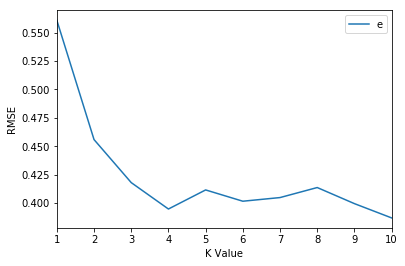

In [24]:
# Plot the above RMSE values against K values

curve = pd.DataFrame(rmse_val)
curve.plot()
plt.legend("error")
plt.xlabel("K Value")
plt.ylabel("RMSE")
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print("3 Nearest Neighbors Accuracy Score (Reg.): ", knn.score(X_test, y_test))

3 Nearest Neighbors Accuracy Score (Reg.):  0.06885462307605872


In [26]:
# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

X = heart.drop(columns='heart_disease')
y = heart['heart_disease']

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print("3 Nearest Neighbors Accuracy Score (Class.): ", knn.score(X_test, y_test))

3 Nearest Neighbors Accuracy Score (Class.):  0.6741573033707865


## Random Forest Classification

In [27]:
from sklearn.ensemble import RandomForestClassifier as rf

rf = rf(n_estimators = 1000, random_state = 1)
rf.fit(X_train, y_train)

acc = rf.score(X_test, y_test)

print("Random Forest Accuracy Score: ", acc)

Random Forest Accuracy Score:  0.8202247191011236


## Decision Tree Classifier & Visualization

In [29]:
from sklearn.tree import DecisionTreeClassifier

features = heart.drop(columns='heart_disease')
target = heart.heart_disease

# Create classifier object
dtree = DecisionTreeClassifier(random_state=0)

# Train
model = dtree.fit(features, target)

In [77]:
# Viasualize
import pydotplus
from IPython.display import Image
from sklearn import tree

# Create DOT data
dot_data = tree.export_graphviz(dtree, feature_names=heart.drop(columns='heart_disease').columns.values, class_names="01")

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save graph
graph.write_png("decision_tree.png")

True

![Decision Tree Visualization](decision_tree.png)